# Kernel Perceptron 2022
### Christian Igel

Let me know if you have suggestions to improve this notebook.

Some general stuff first:

In [1]:
import numpy as np
import math

from sklearn.datasets import make_classification, make_moons, make_circles

import ipywidgets as widgets

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# Default figure size in inches
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [64]:
def rbf_kernel(xi, xj, sigma=5, axis=2):
    return np.exp(- np.sum((xi-xj)**2 / (2*sigma**2), axis=axis))

def polynomial_kernel(xi, xj, degree=1, bias=False, axis=2):
    return (np.sum(xi*xj, axis=axis) + bias)**degree

class KernelPerceptron:
    """
    Kernel perceptron based on inplementation by Kristoffer Stensbo-Smidt.
    """
    def __init__(self, kernel="rbf", sigma=5, degree=1, bias=False, max_iter=100):
        
        if kernel == "rbf":
            self.kernel = lambda x,y,**kwargs: rbf_kernel(x,y,sigma,**kwargs)
        elif kernel == "poly":
            self.kernel = lambda x,y,**kwargs: polynomial_kernel(x,y,degree,bias,**kwargs)
        
        self.max_iter = max_iter
        
                    
    def fit(self, X, y):
        n_samples = X.shape[0]
        alpha = np.zeros(n_samples)

        total_error = 1e6
        self.it = 0
        
        # Store all possible kernel calculations to avoid recomputation,
        # that is, we cache the Gram matrix
        xi, xj = np.meshgrid(range(n_samples), range(n_samples))
        K = self.kernel(X[xj], X[xi])

        # Perceptron learning
        while total_error > 0 and self.it < self.max_iter:
            total_error = 0
            self.it += 1
            
            for i in range(n_samples):
                 #if np.sign(np.sum(K[:,i] * alpha * y)) != y[i]:
                 if y[i] * np.sum(K[:,i] * alpha * y) < 1 : # change
                    alpha[i] += 1
                    total_error += 1
            
        
        # Store only samples with alpha > 0 (i.e., the "support vectors"):
        inds = np.where(alpha > 0)
        self.alpha = alpha[inds]
        self.svx = X[inds]
        self.svy = y[inds]
       
    
    def project(self, X):
        """
        Convenience function to speed up plotting. The sign of this is the
        proper prediction.
        """
        
        p = np.zeros(X.shape[0])
        
        for i, svx in enumerate(self.svx):
            svxi = np.tile(svx, (X.shape[0], 1))
            p += self.alpha[i] * self.svy[i] * self.kernel(svxi, X, axis=1)

        return p      
    
    
    def predict(self, X):
        return np.sign(self.project(X))  
    
    
def plot_interactive_perceptron(X, y, res=200, max_iter=100):
    """
    Create an interactive kernel perceptron plot. Set 'res' to a low value for a finer
    grid (i.e. higher resolution of the background).
    """
    class_colours = ['b' if i==-1 else 'r' for i in y]
    
    xl, xh = np.floor(X[:,0].min() - 0.1), np.ceil(X[:,0].max() + 0.1)
    yl, yh = np.floor(X[:,1].min() - 0.1), np.ceil(X[:,1].max() + 0.1)
     
    # Create grid to calculate the decision boundary on:
    xx, yy = np.meshgrid(np.linspace(xl, xh, res), np.linspace(yl, yh, res))

    def f(sigma, degree, bias, kernel):
        
        boolbias = 1 if bias == 'yes' else 0
        
        clf = KernelPerceptron(kernel=kernel, sigma=sigma, degree=degree, bias=boolbias, max_iter=max_iter)
        clf.fit(X, y)

        Z = clf.project(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
                
        plt.figure(42)
        ax = plt.gca()
        
        # Plot data:
        ax.scatter(X[:,0], X[:,1], s=45, c=class_colours,
                   edgecolor=mpl.cm.gray(.95), lw=0.5, zorder=100)

        # Plot decision function:
        plt.contourf(xx, yy, Z, [-1e100,0.0,1e100], cmap=mpl.cm.coolwarm, 
                     origin='lower', alpha=.6, zorder=-10)
        
        plt.contour(xx,yy,Z, levels=[0], colors=[mpl.cm.gray(.95)], 
                    linestyles=["solid"], linewidths=2)
        
        ax.xaxis.set_ticks_position('bottom')
        ax.grid(False)
        plt.xlim(xl, xh)
        plt.ylim(yl, yh)
        plt.show()

    _ = widgets.interact(f, 
                        kernel=widgets.RadioButtons(options=( "rbf","poly")),
                        sigma=widgets.FloatSlider(min=.01, max=1,
                                                step=.01, value=0.1, continuous_update=False),
                        degree=widgets.IntSlider(min=1, max=10,
                                                step=1, value=1, continuous_update=False),
                        bias=widgets.RadioButtons(options=['yes', 'no'], value='no'),
                        continuous_update=False)
    

## An easy problem

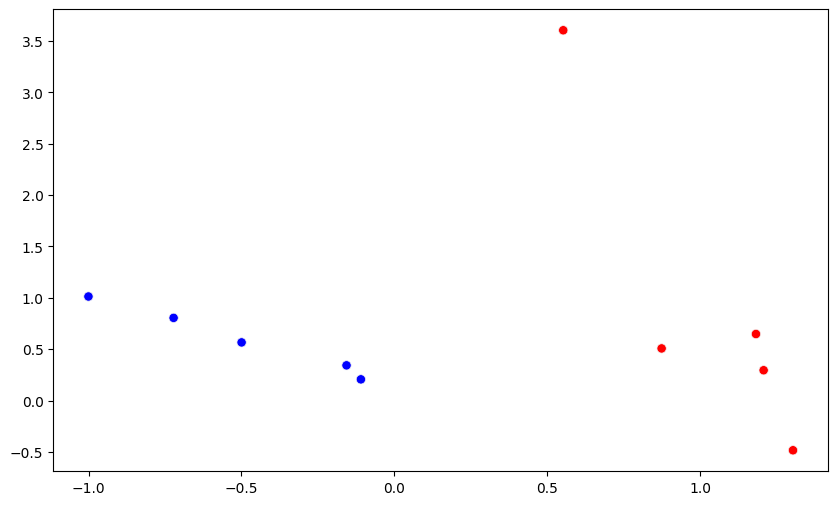

In [30]:
X, y = make_classification(n_samples=10, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=0)
y = 2*y - 1  # ensure y \in {-1,+1} 
plt.scatter(X[:,0], X[:,1], s=45, c=['r' if i == 1 else 'b' for i in y], edgecolor=mpl.cm.gray(.95), lw=0.5);

In [63]:
plot_interactive_perceptron(X,y,max_iter=1000)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma', max=1.0, min=0.01, …

## Some harder problems

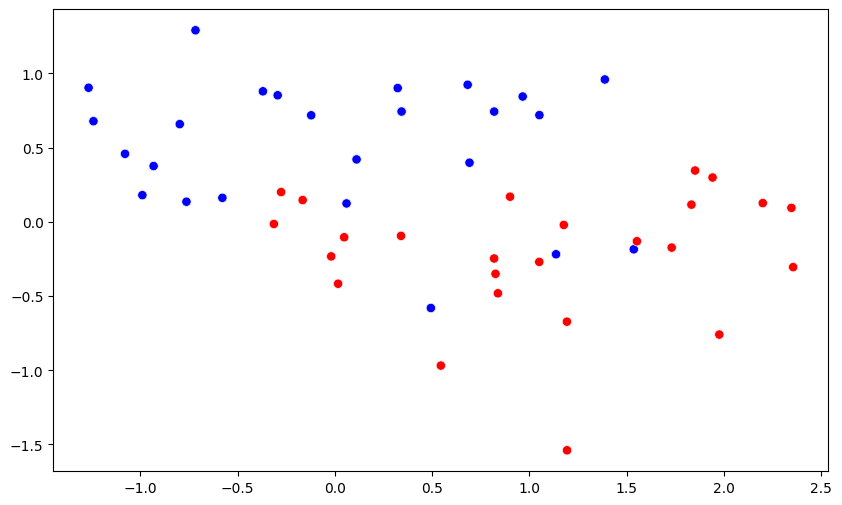

In [53]:
X, y = make_moons(n_samples=50, noise=.3, random_state=2)
y = 2*y - 1
plt.scatter(X[:,0], X[:,1], s=45, c=['r' if i == 1 else 'b' for i in y], edgecolor=mpl.cm.gray(.95), lw=0.5);

In [65]:
plot_interactive_perceptron(X,y,max_iter=1000)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma', max=1.0, min=0.01, …

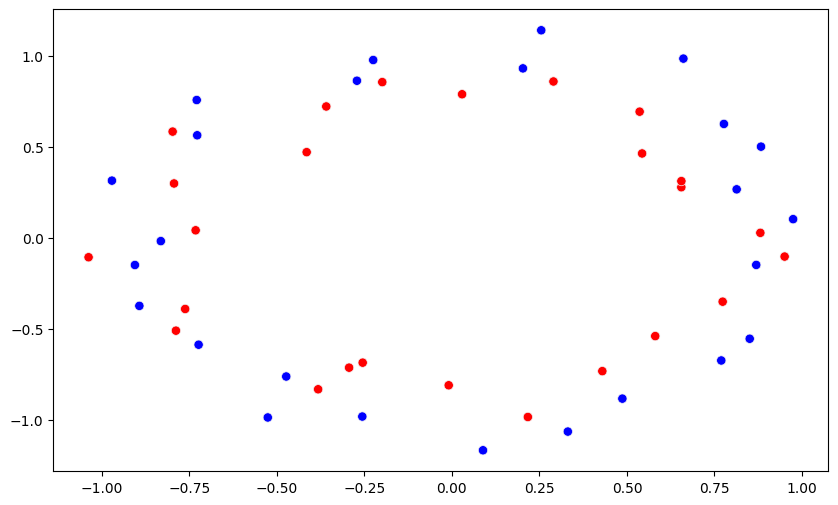

In [49]:
X, y = make_circles(n_samples=50, noise=.1, random_state=0)
y = 2*y - 1
plt.scatter(X[:,0], X[:,1], s=45, c=['r' if i == 1 else 'b' for i in y], edgecolor=mpl.cm.gray(.95), lw=0.5);

In [50]:
plot_interactive_perceptron(X,y,max_iter=10000)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma', max=1.0, min=0.01, …

In [11]:
def gen_non_lin_separable_data(random_state=0):
    np.random.seed(random_state)
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    x1 = np.random.multivariate_normal(mean1, cov, 50)
    x2 = np.random.multivariate_normal(mean2, cov, 50)
    x3 = np.random.multivariate_normal(mean3, cov, 50)
    x4 = np.random.multivariate_normal(mean4, cov, 50)
    X = np.vstack((x1,x2,x3,x4))
    y1 = np.ones(len(x1))
    y2 = np.ones(len(x2))*-1
    y3 = np.ones(len(x3))
    y4 = np.ones(len(x4))*-1
    y = np.hstack((y1,y2,y3,y4))
    return X, y

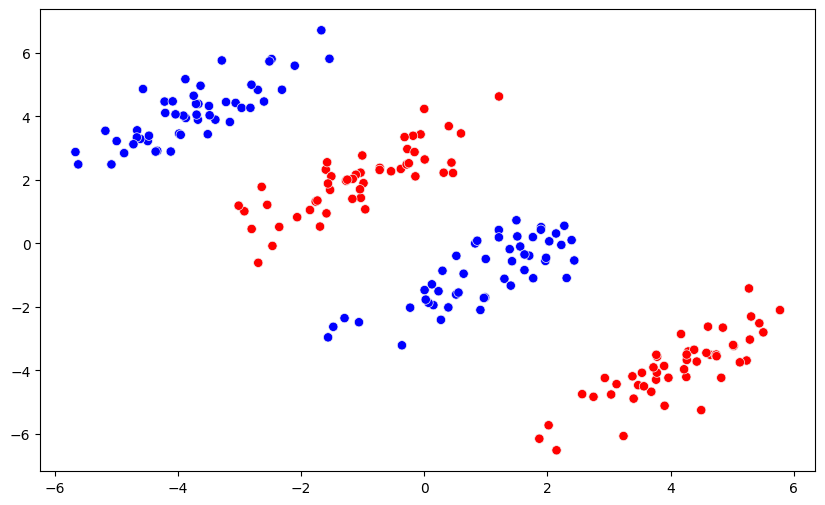

In [51]:
X, y = gen_non_lin_separable_data()
plt.scatter(X[:,0], X[:,1], s=45, c=['r' if i == 1 else 'b' for i in y], edgecolor=mpl.cm.gray(.95), lw=0.5);

In [52]:
plot_interactive_perceptron(X,y)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='sigma', max=1.0, min=0.01, …